In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'imdb-dataset-of-50k-movie-reviews:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F134715%2F320111%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240808%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240808T192058Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7c7ee665e09f04824f1583834dc9a959fc4c335f45885f0f0c28d342c4d7edae407abf1b5225ce1569ce7084c1f9811d8b2feea3cbabe9c40d00ab599b6f0c0c7d56b5e4267aaeeadad440825be1e368b46a5fc150916e742b18be64496eadba38b345591ae8fcdff6233cacc79d9280627cb617aa381514a5837d69d4a4f883dbc4c3fc4d2e51dfc4719cb565dc58de081d4e2a3b7ba57f8e0650bfa568cbe0db8b82adcbad1b5976f5af2e93ea531348f49971c3f783bc90b772c7de750481be1b0f8b3a57a7033eb3b4faec3804bc26f2b3c24bcc54bdf42dc49a345a588fd690ed0d344c967fcc2727bb980970c54f946f7081908871fb1e9e5605be3dbf'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 26962657 bytes downloaded
Downloaded and uncompressed: imdb-dataset-of-50k-movie-reviews
Data source import complete.


# Sentiment Analysis of IMDb Reviews

## Introduction

In this project, we aim to analyze the sentiment of IMDb reviews using various sentiment analysis techniques. The objective is to evaluate and compare the performance of different sentiment analysis methods, ranging from traditional lexicon-based approaches to advanced deep learning models.

## Methods Used

We will implement and evaluate the following sentiment analysis techniques:

1. **VADER (Valence Aware Dictionary and sEntiment Reasoner)**:
   - A lexicon and rule-based sentiment analysis tool specifically attuned to sentiments expressed in social media.

2. **TextBlob**:
   - A simple and intuitive tool for processing textual data, providing a simple API for common natural language processing tasks including sentiment analysis.

3. **RoBERTa (Robustly optimized BERT approach)**:
   - A transformer-based model optimized for NLP tasks, used for sentiment classification.

4. **DistilBERT**:
   - A smaller, faster, cheaper, and lighter version of BERT optimized for efficiency.

5. **Hugging Face Sentiment Analysis Pipeline**:
   - A pre-trained pipeline from Hugging Face, offering a straightforward interface to perform sentiment analysis using state-of-the-art models.

## Project Outline

1. **Load the Dataset**:
   - Load the IMDb reviews dataset and preprocess it for sentiment analysis.

2. **Implement Sentiment Analysis Techniques**:
   - Apply each of the five sentiment analysis methods to the dataset.

3. **Evaluate Accuracy**:
   - Calculate the accuracy of each method by comparing the predicted sentiments with the actual sentiments in the dataset.

4. **Visualize Results**:
   - Plot the results to visually compare the performance of each sentiment analysis technique.

5. **Comparison of Results**:
   - Provide a comparative analysis of the accuracies of all the methods used.

By the end of this notebook, you will have a comprehensive understanding of the strengths and weaknesses of different sentiment analysis methods, enabling you to choose the most suitable approach for your specific needs.

Let's dive in and explore the fascinating world of sentiment analysis!


# Load the dataset

In [2]:
import pandas as pd

# Load dataset
df = pd.read_csv('../input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')

# Drop null values
df = df.dropna(subset=['review', 'sentiment'])

# Preview the data
df.head()

# Stick to 250 for keeping it fast
df = df.head(500)
df[:10]

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


# Implement Sentiment Analysis Techniques

## VADER

In [3]:
import nltk  # NLP toolkit
from nltk.sentiment import SentimentIntensityAnalyzer  # VADER sentiment analysis
import matplotlib.pyplot as plt  # Plotting library
import pandas as pd  # Data manipulation
import seaborn as sns  # Advanced plotting

In [4]:
# pre-defined list of lexical features (words, phrases, etc.) that are commonly used to express sentiments
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [5]:
# Define function to get VADER sentiment
def get_vader_scores(text):
    score = sia.polarity_scores(text)
    return score['compound']

In [6]:
# Apply VADER sentiment analysis to get scores
df['vader_score'] = df['review'].apply(get_vader_scores)

# Classify the VADER scores into sentiments
df['vader_sentiment'] = df['vader_score'].apply(lambda x: 'positive' if x >= 0 else 'negative')

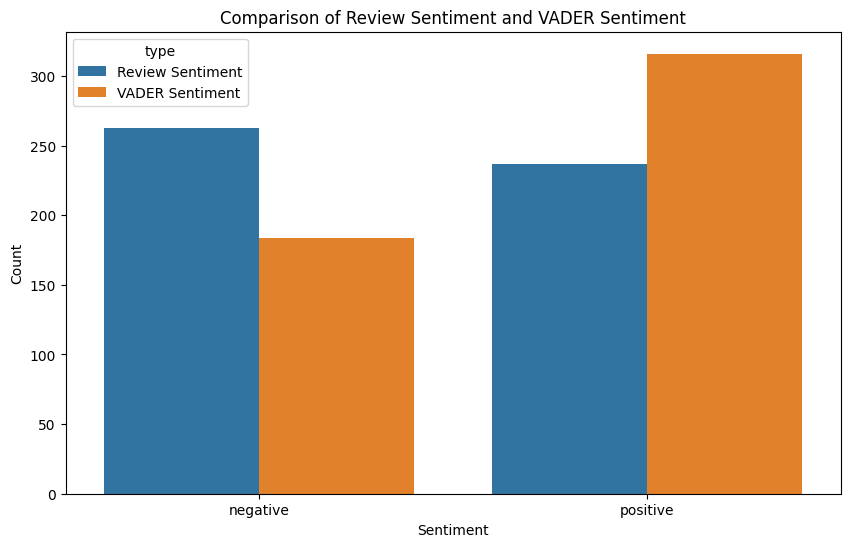

In [7]:
# Calculate counts for each sentiment type
sentiment_counts = df['sentiment'].value_counts().reset_index()
sentiment_counts.columns = ['sentiment', 'count']
sentiment_counts['type'] = 'Review Sentiment'

vader_sentiment_counts = df['vader_sentiment'].value_counts().reset_index()
vader_sentiment_counts.columns = ['sentiment', 'count']
vader_sentiment_counts['type'] = 'VADER Sentiment'

# Combine the data
combined_counts = pd.concat([sentiment_counts, vader_sentiment_counts])

# Plot results
plt.figure(figsize=(10, 6))
sns.barplot(data=combined_counts, x='sentiment', y='count', hue='type')
plt.title('Comparison of Review Sentiment and VADER Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [8]:
# Extract examples
examples = {
    'USER - Positive, VADER - Positive': df[(df['sentiment'] == 'positive') & (df['vader_sentiment'] == 'positive')].iloc[0],
    'USER - Negative, VADER - Negative': df[(df['sentiment'] == 'negative') & (df['vader_sentiment'] == 'negative')].iloc[0],
    'USER - Positive, VADER - Negative': df[(df['sentiment'] == 'positive') & (df['vader_sentiment'] == 'negative')].iloc[0],
    'USER - Negative, VADER - Positive': df[(df['sentiment'] == 'negative') & (df['vader_sentiment'] == 'positive')].iloc[0],
}

# Display examples
for key, value in examples.items():
    value['review'] = value['review'].replace("<br /><br />", "\n")
    print(f"{key}: \n {value['review']}\n")

USER - Positive, VADER - Positive: 
 A wonderful little production. 
The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. 
The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. 
The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well don

In [9]:
df[:5]

,review,sentiment,vader_score,vader_sentiment
0,One of the other reviewers has mentioned that ...,positive,-0.9951,negative
1,A wonderful little production. <br /><br />The...,positive,0.9641,positive
2,I thought this was a wonderful way to spend ti...,positive,0.9605,positive
3,Basically there's a family where a little boy ...,negative,-0.9213,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,0.9744,positive


## TextBlob

In [10]:
# TextBlob makes it easy to perform various text processing tasks
# It can handle tokenization, word inflection, and lemmatization
from textblob import TextBlob

In [11]:
# Define function to get TextBlob sentiment score
def get_textblob_scores(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

In [12]:
# Apply TextBlob sentiment analysis to get scores
df['textblob_score'] = df['review'].apply(get_textblob_scores)

# Classify the TextBlob scores into sentiments
df['textblob_sentiment'] = df['textblob_score'].apply(lambda x: 'positive' if x >= 0 else 'negative')

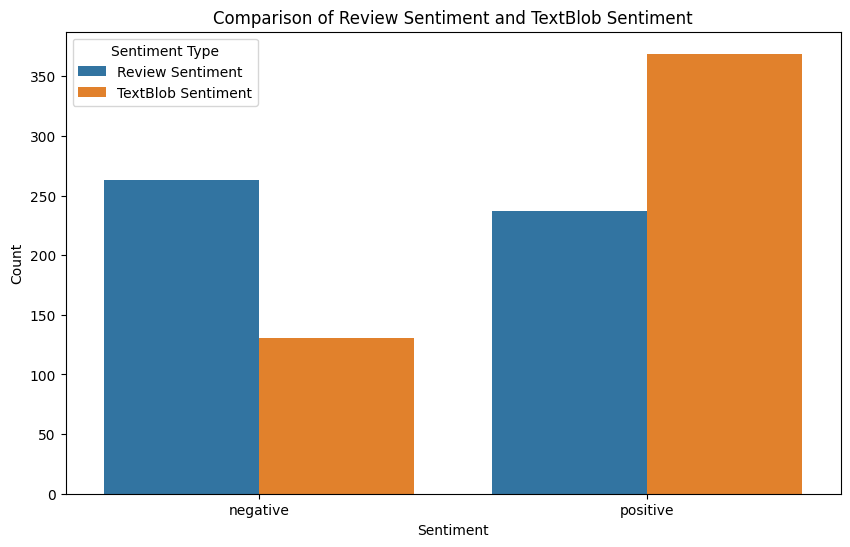

In [13]:
# Calculate counts for each sentiment type
sentiment_counts = df['sentiment'].value_counts().reset_index()
sentiment_counts.columns = ['sentiment', 'count']
sentiment_counts['type'] = 'Review Sentiment'

textblob__sentiment_counts = df['textblob_sentiment'].value_counts().reset_index()
textblob__sentiment_counts.columns = ['sentiment', 'count']
textblob__sentiment_counts['type'] = 'TextBlob Sentiment'

# Combine the data
combined_counts = pd.concat([sentiment_counts, textblob__sentiment_counts])

# Plot results
plt.figure(figsize=(10, 6))
sns.barplot(data=combined_counts, x='sentiment', y='count', hue='type')
plt.title('Comparison of Review Sentiment and TextBlob Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.legend(title='Sentiment Type')
plt.show()

In [14]:
# Extract examples
examples = {
    'USER - Positive, TextBlob - Positive': df[(df['sentiment'] == 'positive') & (df['textblob_sentiment'] == 'positive')].iloc[0],
    'USER - Negative, TextBlob - Negative': df[(df['sentiment'] == 'negative') & (df['textblob_sentiment'] == 'negative')].iloc[0],
    'USER - Positive, TextBlob - Negative': df[(df['sentiment'] == 'positive') & (df['textblob_sentiment'] == 'negative')].iloc[0],
    'USER - Negative, TextBlob - Positive': df[(df['sentiment'] == 'negative') & (df['textblob_sentiment'] == 'positive')].iloc[0],
}

# Display examples
for key, value in examples.items():
    value['review'] = value['review'].replace("<br /><br />", "\n")
    print(f"{key}: \n{value['review']}\n")


USER - Positive, TextBlob - Positive: 
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.
The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.
It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.
I would say the main appeal of the show is due to t

In [15]:
df[:5]

,review,sentiment,vader_score,vader_sentiment,textblob_score,textblob_sentiment
0,One of the other reviewers has mentioned that ...,positive,-0.9951,negative,0.023433,positive
1,A wonderful little production. <br /><br />The...,positive,0.9641,positive,0.109722,positive
2,I thought this was a wonderful way to spend ti...,positive,0.9605,positive,0.354008,positive
3,Basically there's a family where a little boy ...,negative,-0.9213,negative,-0.057813,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,0.9744,positive,0.217952,positive


## RoBERTA

In [16]:
# Transformers: deep learning model architecture designed for handling sequential data
# AutoTokenizer: converts raw text into a format that the model can process
# AutoModelForSequenceClassification: It processes the tokenized input and outputs logits for each class.
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# This line converts the logits output by the RoBERTa model into probabilities
from scipy.special import softmax
import torch

In [17]:
# RoBERTa Model
roberta_model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
roberta_tokenizer = AutoTokenizer.from_pretrained(roberta_model_name)
roberta_model = AutoModelForSequenceClassification.from_pretrained(roberta_model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Steps
1. Tokenization and Tensor Conversion: The tokenizer converts the input text into tokens and then into tensors (return_tensors='pt' indicates PyTorch tensors)
2. Model Inference: The with torch.no_grad() block ensures that the model runs in inference mode, which reduces memory usage and speeds up the computation as gradients are not calculated
3. Extracting Logits: The output.logits contains the raw prediction scores from the model, which are then converted to a NumPy array for further processing

In [18]:
def get_roberta_sentiment(text):
    # Tokenize the input text, truncate it if it's longer than 512 tokens, and convert it to a PyTorch tensor
    encoded_text = roberta_tokenizer(text, truncation=True, padding=True, max_length=512, return_tensors='pt')

    # Disable gradient calculations for inference to save memory and computation
    with torch.no_grad():
        # Get the model's output (logits) for the encoded text
        output = roberta_model(**encoded_text)

    # Extract the logits from the model output and convert them to a NumPy array
    scores = output.logits[0].detach().numpy()

    # Apply the softmax function to convert logits to probabilities
    scores = softmax(scores)

    # Determine the sentiment based on the highest probability score
    sentiment = ['negative', 'neutral', 'positive'][scores.argmax()]

    # Get the highest probability score
    score = scores[scores.argmax()]

    # Return the sentiment label and the corresponding score
    return sentiment, score

In [ ]:
# Apply RoBERTa sentiment analysis
df[['roberta_sentiment', 'roberta_score']] = df['review'].apply(lambda x: pd.Series(get_roberta_sentiment(x)))

In [ ]:
# Extract examples
examples = {
    'USER - Positive, RoBERTa - Positive': df[(df['sentiment'] == 'positive') & (df['roberta_sentiment'] == 'positive')].iloc[0],
    'USER - Negative, RoBERTa - Negative': df[(df['sentiment'] == 'negative') & (df['roberta_sentiment'] == 'negative')].iloc[0],
    'USER - Positive, RoBERTa - Negative': df[(df['sentiment'] == 'positive') & (df['roberta_sentiment'] == 'negative')].iloc[0],
    'USER - Negative, RoBERTa - Positive': df[(df['sentiment'] == 'negative') & (df['roberta_sentiment'] == 'positive')].iloc[0],
}

# Display examples
for key, value in examples.items():
    value['review'] = value['review'].replace("<br /><br />", "\n")
    print(f"{key}: \n{value['review']}\nRoBERTa Score: {value['roberta_score']}\n")

In [ ]:
# Calculate counts for each sentiment type for RoBERTa
roberta_sentiment_counts = df['roberta_sentiment'].value_counts().reset_index()
roberta_sentiment_counts.columns = ['sentiment', 'count']
roberta_sentiment_counts['type'] = 'RoBERTa Sentiment'

# Calculate counts for each sentiment type for the original review
sentiment_counts = df['sentiment'].value_counts().reset_index()
sentiment_counts.columns = ['sentiment', 'count']
sentiment_counts['type'] = 'Review Sentiment'

# Combine the data
combined_counts = pd.concat([sentiment_counts, roberta_sentiment_counts])

# Plot results
plt.figure(figsize=(10, 6))
sns.barplot(data=combined_counts, x='sentiment', y='count', hue='type')
plt.title('Comparison of Review Sentiment and RoBERTa Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.legend(title='Sentiment Type')
plt.show()

In [ ]:
df[:5]

## DistilBERT

In [ ]:
# DistilBERT Model
distilbert_model_name = "lxyuan/distilbert-base-multilingual-cased-sentiments-student"
distilbert_tokenizer = AutoTokenizer.from_pretrained(distilbert_model_name)
distilbert_model = AutoModelForSequenceClassification.from_pretrained(distilbert_model_name)

In [ ]:
def get_distilbert_sentiment(text):
    encoded_text = distilbert_tokenizer(text, truncation=True, padding=True, max_length=512, return_tensors='pt')
    with torch.no_grad():
        output = distilbert_model(**encoded_text)
    scores = output.logits[0].detach().numpy()
    scores = softmax(scores)
    sentiment = ['negative', 'neutral', 'positive'][scores.argmax()]
    score = scores[scores.argmax()]
    return sentiment, score

In [ ]:
# Apply DistilBERT sentiment analysis
df[['distilbert_sentiment', 'distilbert_score']] = df['review'].apply(lambda x: pd.Series(get_distilbert_sentiment(x)))

In [ ]:
# Calculate counts for each sentiment type
sentiment_counts = df['sentiment'].value_counts().reset_index()
sentiment_counts.columns = ['sentiment', 'count']
sentiment_counts['type'] = 'Review Sentiment'

distilbert_sentiment_counts = df['distilbert_sentiment'].value_counts().reset_index()
distilbert_sentiment_counts.columns = ['sentiment', 'count']
distilbert_sentiment_counts['type'] = 'DistilBERT Sentiment'

# Combine the data
combined_counts = pd.concat([sentiment_counts, distilbert_sentiment_counts])

# Plot results
plt.figure(figsize=(10, 6))
sns.barplot(data=combined_counts, x='sentiment', y='count', hue='type')
plt.title('Comparison of Review Sentiment and DistilBERT Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.legend(title='Sentiment Type')
plt.show()

In [ ]:
# Extract examples
examples = {
    'USER - Positive, DistilBERT - Positive': df[(df['sentiment'] == 'positive') & (df['distilbert_sentiment'] == 'positive')].iloc[0],
    'USER - Negative, DistilBERT - Negative': df[(df['sentiment'] == 'negative') & (df['distilbert_sentiment'] == 'negative')].iloc[0],
    'USER - Positive, DistilBERT - Negative': df[(df['sentiment'] == 'positive') & (df['distilbert_sentiment'] == 'negative')].iloc[0],
    'USER - Negative, DistilBERT - Positive': df[(df['sentiment'] == 'negative') & (df['distilbert_sentiment'] == 'positive')].iloc[0],
}

# Display examples
for key, value in examples.items():
    value['review'] = value['review'].replace("<br /><br />", "\n")
    print(f"{key}: \n{value['review']}\nDistilBERT Score: {value['distilbert_score']}\n")

In [ ]:
df[:5]

## Hugging Face Sentiment Analysis Pipeline

In [ ]:
from transformers import pipeline

# Create a sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis")

In [ ]:
def get_pipeline_sentiment(text):
    result = sentiment_pipeline(text[:512])[0]  # Ensure text is within the token limit
    sentiment = 'positive' if result['label'] == 'POSITIVE' else 'negative'
    score = result['score']
    return sentiment, score

In [ ]:
# Apply sentiment analysis pipeline
df[['pipeline_sentiment', 'pipeline_score']] = df['review'].apply(lambda x: pd.Series(get_pipeline_sentiment(x)))

In [ ]:
# Calculate counts for each sentiment type
sentiment_counts = df['sentiment'].value_counts().reset_index()
sentiment_counts.columns = ['sentiment', 'count']
sentiment_counts['type'] = 'Review Sentiment'

pipeline_sentiment_counts = df['pipeline_sentiment'].value_counts().reset_index()
pipeline_sentiment_counts.columns = ['sentiment', 'count']
pipeline_sentiment_counts['type'] = 'Pipeline Sentiment'

# Combine the data
combined_counts = pd.concat([sentiment_counts, pipeline_sentiment_counts])

# Plot results
plt.figure(figsize=(10, 6))
sns.barplot(data=combined_counts, x='sentiment', y='count', hue='type')
plt.title('Comparison of Review Sentiment and Pipeline Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.legend(title='Sentiment Type')
plt.show()



In [ ]:
# Extract examples
examples = {
    'USER - Positive, Pipeline - Positive': df[(df['sentiment'] == 'positive') & (df['pipeline_sentiment'] == 'positive')].iloc[0],
    'USER - Negative, Pipeline - Negative': df[(df['sentiment'] == 'negative') & (df['pipeline_sentiment'] == 'negative')].iloc[0],
    'USER - Positive, Pipeline - Negative': df[(df['sentiment'] == 'positive') & (df['pipeline_sentiment'] == 'negative')].iloc[0],
    'USER - Negative, Pipeline - Positive': df[(df['sentiment'] == 'negative') & (df['pipeline_sentiment'] == 'positive')].iloc[0],
}

# Display examples
for key, value in examples.items():
    value['review'] = value['review'].replace("<br /><br />", "\n")
    print(f"{key}: \n{value['review']}\nPipeline Score: {value['pipeline_score']}\n")

In [ ]:
df[:5]

## Comparisons

### Accuracy Comparison

In [ ]:
# Calculate the accuracy of each sentiment analysis model compared to the user-provided sentiments.
vader_accuracy = (df['sentiment'] == df['vader_sentiment']).mean()
textblob_accuracy = (df['sentiment'] == df['textblob_sentiment']).mean()
roberta_accuracy = (df['sentiment'] == df['roberta_sentiment']).mean()
distilbert_accuracy = (df['sentiment'] == df['distilbert_sentiment']).mean()
pipeline_accuracy = (df['sentiment'] == df['pipeline_sentiment']).mean()

print(f"VADER Accuracy: {vader_accuracy}")
print(f"TextBlob Accuracy: {textblob_accuracy}")
print(f"RoBERTa Accuracy: {roberta_accuracy}")
print(f"DistilBERT Accuracy: {distilbert_accuracy}")
print(f"Pipeline Accuracy: {pipeline_accuracy}")

### Confusion Matrices

In [ ]:
# Confusion matrices to visualize the performance of each model against the user-provided sentiments.
from sklearn.metrics import confusion_matrix

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Confusion matrix for VADER
cm_vader = confusion_matrix(df['sentiment'], df['vader_sentiment'], labels=['positive', 'negative'])
sns.heatmap(cm_vader, annot=True, fmt='d', cmap='Blues', xticklabels=['positive', 'negative'], yticklabels=['positive', 'negative'], ax=axes[0, 0])
axes[0, 0].set_title('Confusion Matrix for VADER')
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('Actual')

# Confusion matrix for TextBlob
cm_textblob = confusion_matrix(df['sentiment'], df['textblob_sentiment'], labels=['positive', 'negative'])
sns.heatmap(cm_textblob, annot=True, fmt='d', cmap='Blues', xticklabels=['positive', 'negative'], yticklabels=['positive', 'negative'], ax=axes[0, 1])
axes[0, 1].set_title('Confusion Matrix for TextBlob')
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('Actual')

# Confusion matrix for RoBERTa
cm_roberta = confusion_matrix(df['sentiment'], df['roberta_sentiment'], labels=['positive', 'negative'])
sns.heatmap(cm_roberta, annot=True, fmt='d', cmap='Blues', xticklabels=['positive', 'negative'], yticklabels=['positive', 'negative'], ax=axes[0, 2])
axes[0, 2].set_title('Confusion Matrix for RoBERTa')
axes[0, 2].set_xlabel('Predicted')
axes[0, 2].set_ylabel('Actual')

# Confusion matrix for DistilBERT
cm_distilbert = confusion_matrix(df['sentiment'], df['distilbert_sentiment'], labels=['positive', 'negative'])
sns.heatmap(cm_distilbert, annot=True, fmt='d', cmap='Blues', xticklabels=['positive', 'negative'], yticklabels=['positive', 'negative'], ax=axes[1, 0])
axes[1, 0].set_title('Confusion Matrix for DistilBERT')
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Actual')

# Confusion matrix for Hugging Face Pipeline
cm_pipeline = confusion_matrix(df['sentiment'], df['pipeline_sentiment'], labels=['positive', 'negative'])
sns.heatmap(cm_pipeline, annot=True, fmt='d', cmap='Blues', xticklabels=['positive', 'negative'], yticklabels=['positive', 'negative'], ax=axes[1, 1])
axes[1, 1].set_title('Confusion Matrix for Hugging Face Pipeline')
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('Actual')

# Adjust layout
plt.tight_layout()
plt.show()

### Sentiment Score Distribution

In [ ]:
# Visualize the distribution of sentiment scores for each model to understand their confidence levels.
plt.figure(figsize=(10, 6))
sns.histplot(df['vader_score'], kde=True, color='blue', label='VADER')
sns.histplot(df['textblob_score'], kde=True, color='green', label='TextBlob')
sns.histplot(df['roberta_score'], kde=True, color='red', label='RoBERTa')
sns.histplot(df['distilbert_score'], kde=True, color='purple', label='DistilBERT')
sns.histplot(df['pipeline_score'], kde=True, color='orange', label='Pipeline')
plt.legend()
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

### Disagreement Analysis

In [ ]:
# Identify instances where models disagree with each other and the user-provided sentiment. This can highlight where models struggle
disagreement = df[(df['sentiment'] != df['vader_sentiment']) |
                  (df['sentiment'] != df['textblob_sentiment']) |
                  (df['sentiment'] != df['roberta_sentiment']) |
                  (df['sentiment'] != df['distilbert_sentiment']) |
                  (df['sentiment'] != df['pipeline_sentiment'])]

print(f'{len(disagreement)} out of {len(df)}')
print(disagreement[:10])

### Sentiment Agreement

In [ ]:
agreement_matrix = pd.DataFrame({
    'VADER': df['vader_sentiment'] == df['sentiment'],
    'TextBlob': df['textblob_sentiment'] == df['sentiment'],
    'RoBERTa': df['roberta_sentiment'] == df['sentiment'],
    'DistilBERT': df['distilbert_sentiment'] == df['sentiment'],
    'Pipeline': df['pipeline_sentiment'] == df['sentiment']
}).mean()

print(agreement_matrix)

### Summary statistics for all scores

In [ ]:
print("Summary Statistics for Sentiment Scores:")
print(df[['vader_score', 'textblob_score', 'roberta_score', 'distilbert_score', 'pipeline_score']].describe())